## Train and Prediction on valid

Using rotated to hz + OpenCv border

Basic default transforms

Densenet

at bs=32 only using 1.8GB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from callbacks import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from torchvision.models import densenet121

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101'

In [10]:
NB_NUM='06_14'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 204ea792, DATE: 20191126


In [12]:
#DATE = '20191126'
#UID = 'b8154638'

In [13]:
SUB_NUM='7'

In [14]:
img_size=256
bs=64

In [15]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [16]:
### add St Lucia pred cement as valid

In [17]:
df_all=pd.read_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [18]:
df_all.drop(columns=['target'],inplace=True)

In [19]:
df_valid=df_all.loc[df_all['verified'] == True]

In [20]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [21]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [22]:
df_all.loc[df_all['id'] == '7a204ec4']

,country,id,region,roof_material,verified
12960,guatemala,7a204ec4,mixco_1_and_ebenezer,irregular_metal,True


In [23]:
len(df_all)

22539

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [24]:
xtra_tfms=[rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_zoom=1.2, max_warp=0., xtra_tfms=xtra_tfms)

### setup dataset

In [25]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

14945


In [26]:
data = (src.transform(tfms, size=256)
        .databunch(bs=bs).normalize(imagenet_stats))

In [27]:
#to check what params object has
#dir(data)

In [28]:
data.label_list

LabelLists;

Train: LabelList (13451 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (1494 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,concrete_cement,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [29]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

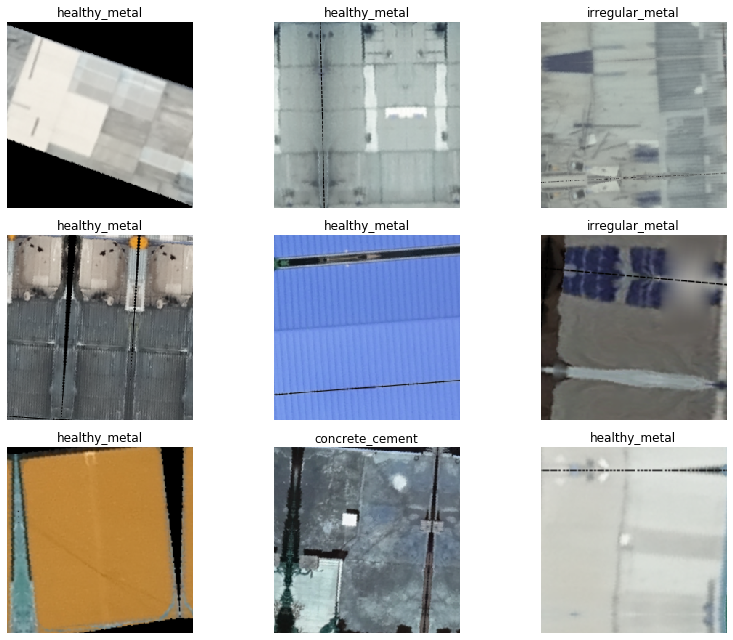

In [30]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [36]:
arch = models.xresnet50()
arch_name = 'xrn50'

In [37]:
opt_func = partial(optim.Adam, eps=0.1, betas=(0.9,0.99))

In [38]:
learn = Learner(data, arch, metrics=[accuracy,top_k_accuracy], wd=1e-3,
        opt_func=opt_func, bn_wd=False, true_wd=True,
        loss_func = LabelSmoothingCrossEntropy()).mixup(alpha=0.2)

learn.callback_fns += [
        partial(GeneralScheduler, phases=(ph1,ph2)),
        partial(SaveModelCallback, every='epoch', name='model')
]

We use the LR Finder to pick a good learning rate.

In [39]:
n_gpus=1
b_its = len(data.train_dl)//n_gpus
lr = 1e-2
tot_epochs = 60

#FP16
n_gpus = 1
b_its = len(data.train_dl)//n_gpus

In [40]:
#learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()
ph1 = (TrainingPhase(tot_epochs*0.10*b_its)
            .schedule_hp('lr', (lr/10,lr),  anneal=annealing_cos))
ph2 = (TrainingPhase(tot_epochs*0.90*b_its)
            .schedule_hp('lr', (lr,lr/1e5), anneal=annealing_cos))

In [41]:
save_name=f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'
save_name

'stage-1-xrn50-06_14-cv_reflect_101-20191126-204ea792'

In [46]:
callbacks = [SaveModelCallback(learn, every='improvement', monitor='val_loss', name=save_name)]
'''
learn.callback_fns += [
        partial(GeneralScheduler, phases=(ph1,ph2)),
        partial(SaveModelCallback, every='epoch', name=save_name)
]
'''

"\nlearn.callback_fns += [\n        partial(GeneralScheduler, phases=(ph1,ph2)),\n        partial(SaveModelCallback, every='epoch', name=save_name)\n]\n"

### Train model

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


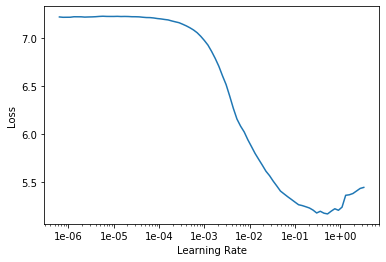

In [44]:
learn.recorder.plot()

Then we can fit the head of our network.

In [47]:
#learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)
learn.fit(tot_epochs, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.927073,1.786942,0.688755,1.000000,01:22
1,1.835871,1.788254,0.700803,1.000000,01:23
2,1.813944,1.785736,0.690763,1.000000,01:23
3,1.828860,1.819699,0.668675,1.000000,01:23
4,1.837611,1.797375,0.682062,1.000000,01:24
5,1.798013,1.719163,0.695448,1.000000,01:25
6,1.774723,1.689727,0.708835,1.000000,01:26
7,1.777861,1.710403,0.686078,1.000000,01:25
8,1.775943,1.792728,0.673360,1.000000,01:25
9,1.744929,1.676434,0.705489,1.000000,01:23


/mnt/963GB/Data/Python/Code/comps/driven_data/caribbean_disaster_risk/fastai/callbacks/tracker.py:50: UserWarning: <class 'callbacks.SaveModelCallback'> conditioned on metric `val_loss` which is not available. Available metrics are: train_loss, valid_loss, accuracy, top_k_accuracy
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


KeyboardInterrupt: 

learn.fit_one_cycle(5, slice(lr),  callbacks=[
                        SaveModelCallbackVerbose(learn=learn,
                                                 monitor='error_rate',
                                                 mode='min',
                                                 name=f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
])

In [42]:
save_name=f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'

In [ ]:
learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.757164,1.674692,0.715529,1.000000,01:19
1,1.789519,1.870700,0.668005,1.000000,01:20
2,1.749141,1.647280,0.728916,1.000000,01:19
3,1.715510,1.585656,0.761044,1.000000,01:19


#### Load model

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 84),
 ('healthy_metal', 'irregular_metal', 78),
 ('incomplete', 'irregular_metal', 22),
 ('concrete_cement', 'healthy_metal', 16),
 ('concrete_cement', 'irregular_metal', 9),
 ('concrete_cement', 'incomplete', 7),
 ('irregular_metal', 'concrete_cement', 6),
 ('irregular_metal', 'incomplete', 6),
 ('other', 'irregular_metal', 6),
 ('other', 'healthy_metal', 4),
 ('healthy_metal', 'concrete_cement', 3),
 ('incomplete', 'concrete_cement', 3),
 ('irregular_metal', 'other', 3),
 ('healthy_metal', 'incomplete', 2),
 ('incomplete', 'healthy_metal', 2)]

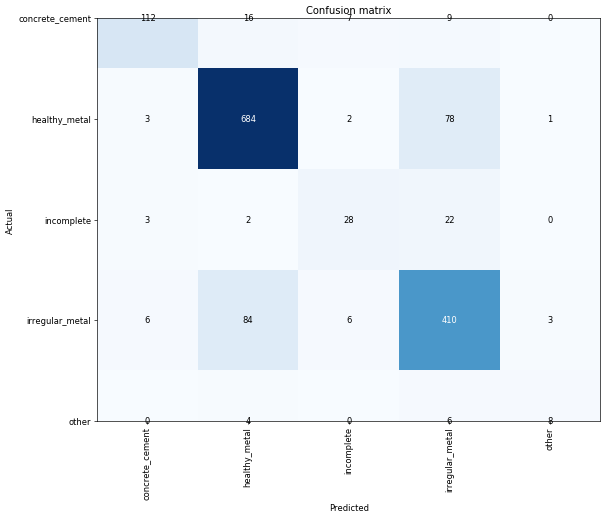

In [45]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [46]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


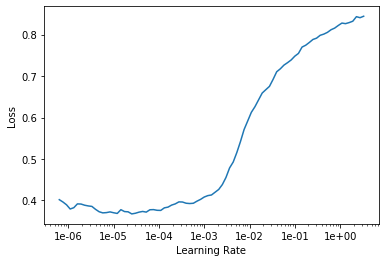

In [47]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
save_name=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'
learn.fit_one_cycle(5, slice(1e-6, lr/5), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.376265,0.461570,0.182731,01:24


In [ ]:
save_name=f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'
learn.fit_one_cycle(5, slice(1e-6, lr/5), callbacks=callbacks)

In [ ]:
learn.recorder.plot_losses()

### Load model and export for inference

In [32]:
learn.load(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2,

In [33]:
learn = learn.to_fp32()

In [34]:
learn.export()

### Larger size images

In [45]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [46]:
learn.freeze()

In [47]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 10.73 GiB total capacity; 8.32 GiB already allocated; 940.06 MiB free; 621.31 MiB cached)

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save(f'stage-1-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


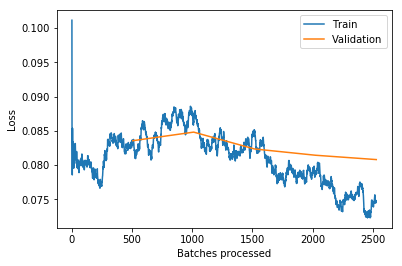

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(f'stage-2-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID})

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

### inference

In [38]:
test_dataset=ImageList.from_folder(test_images)

In [39]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [40]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [41]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [42]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

Get number of items in the Valid dataset (in DeviceDataLoader)

In [43]:
len(learn.dl(DatasetType.Test).dl)

240

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [44]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [45]:
labels = np.argmax(preds, 1)

In [46]:
len(preds)

15325

In [47]:
preds[0].tolist()

[0.5483151078224182,
 0.4485120177268982,
 0.0014102827990427613,
 0.0011081080883741379,
 0.0006545081268996]

In [48]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [49]:
len(labels)

15325

In [50]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [51]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [52]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [53]:
test_predictions[0]

'concrete_cement'

In [54]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [55]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [56]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [57]:
preds_list[0]

[0.5483151078224182,
 0.4485120177268982,
 0.0014102827990427613,
 0.0011081080883741379,
 0.0006545081268996]

In [58]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [59]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [60]:
df.head()

,id,pred
0,7a4d9168,"[0.5483151078224182, 0.4485120177268982, 0.001..."
1,7a4ae922,"[0.003029676154255867, 0.9789470434188843, 0.0..."
2,7a48ca98,"[0.0016933908918872476, 0.11083970963954926, 0..."
3,7a49c614,"[0.0027845362201333046, 0.8177614808082581, 0...."
4,7a4dd4f2,"[0.005415217485278845, 0.7761266827583313, 0.0..."


In [61]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [62]:
pred_df.insert(loc=0, column='id', value=ids)

In [63]:
pred_df.columns = cols

In [64]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.548315,0.448512,0.001410,0.001108,0.000655
1,7a4ae922,0.003030,0.978947,0.001235,0.016447,0.000342
2,7a48ca98,0.001693,0.110840,0.008839,0.877098,0.001530
3,7a49c614,0.002785,0.817761,0.001458,0.176358,0.001638
4,7a4dd4f2,0.005415,0.776127,0.003827,0.184290,0.030341


In [65]:
pred_ids=pred_df['id'].values.tolist()

In [66]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [67]:
baseline_ids=df_baseline['id'].values.tolist()

In [68]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [69]:
pred_df=pred_df.sort_values('id_cat')

In [70]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [71]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [72]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

#### Submission result

sub 8: 0.4947 

In [74]:
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

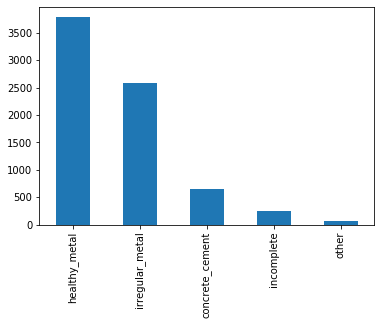

In [75]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")